# Logistic Regression with Numpy

Here we'll attempt to classify the Iris Flower Dataset with a model that we'll build ourselves. 

**Note:** We won't be using any frameworks, we'll just use numpy and plain python.


## The Iris Flower Data set / Fisher's Iris data set
 - https://en.wikipedia.org/wiki/Iris_flower_data_set
 - Multivariate data set introduced by the British statistician and biologist Ronald Fisher in his 1936 paper *The use of multiple measurements in taxonomic problems* as an example of linear discriminant analysis.
 - Input / Feature Names (150 x 4)
     - sepal length (cm)
     - sepal width (cm)
     - petal length (cm)
     - petal width (cm)
 - Output (150 x 1)
    - Iris species label
        0. setosa
        1. versicolor
        2. virginica

- Aim : 
    - Classifying an Iris flower into one of these species based on features
    - ie. Assign a class to given input sample

So as we can see, the dataset consists of **4 input features** and the flowers can be classified as **1 of 3 categorires** as specified above.

## Importing Dependancies

So here are the essentials we'll need to perform the above classification.

*Additionally we'll use matplotlib to visualize the data*

In [218]:
from sklearn import datasets
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import numpy as np
import itertools

%matplotlib inline

## Loading the Dataset

The dataset comes with sklearn as a standard dataset. So we'll use the datasets module within sklearn to load our data.

In [219]:
iris = datasets.load_iris()

X = iris.data.T # Here we take the transposition of the data matrix. 
y = iris.target.reshape((1,150))

print X.shape
print y.shape
print type(y)
order = np.random.permutation(len(X[1]))

(4, 150)
(1, 150)
<type 'numpy.ndarray'>


## One-Hot Encoding

One-hot or One-of-k is a method we'll use to encode our classes such that **no class has any features that will distinctly differentiate them** and **to ensure all the y-values lie between 0 and 1**.

Hence this is how our data will be modified.

|Original Value| One-Hot Encoded|
|--------------|----------------|
|0| [1, 0, 0]|
|1| [0, 1, 0]|
|2| [0, 0, 1]|

Refer [sklearn OneHotEncoder docs](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) for more information. Here since our dataset is small we'll just one-hot encode with a small Python Script.

In [220]:
ohe_y = np.array([[0,0,0]])

for datapoint in y[0]:
    
    if datapoint == 0:
        ohe_y = np.vstack([ohe_y, np.array([1,0,0])])
    elif datapoint == 1:
        ohe_y = np.vstack([ohe_y, np.array([0,1,0])])
    else:
        ohe_y = np.vstack([ohe_y, np.array([0,0,1])])
        
ohe_y = ohe_y[1:,:]
print np.shape(ohe_y)
assert(np.sum(ohe_y, axis=1).all() == 1) # Sanity Check: We're checking that each tuple adds to 1.

(150, 3)


## Splitting Training and Testing Data

Now that we've set up our data let's split it up into **Testing** and **Training** sets.

As we've explained before to proplerly validate our model, we need to ensure that it's trained and tested on mutually exclusive sets of data. 

**Why?**

If we train a model on a set of data, the model will understand the patterns within that dataset and may even perform well during training. But since it's already fit to that data the testing accuracy will be high. Hence we need to ensure that the model is tested on unseen data so as to properly understand it's performance.

In [221]:
# Shuffling data
order = np.random.permutation(len(X[1]))
portion = 30

# Splitting data into train and test 
# samples 0-19  : Test set
# samples 20-99 : Train set
test_x = X[:,order[:portion]]
test_y = ohe_y[order[:portion],:]
test_y_non_ohe = y[:,order[:portion]]
train_x = X[:,order[portion:]]
train_y = ohe_y[order[portion:],:]

print ("Training dataset shape")
print (train_x.shape)
print (train_y.shape)
print
print ("Test dataset shape")
print (test_x.shape)
print (test_y.shape)

Training dataset shape
(4, 120)
(120, 3)

Test dataset shape
(4, 30)
(30, 3)


### Foreword Before Moving On

Past this point we'll be using some formulae that we **just define** as is. We don't provide any derivations and hopefully we get to covering that in person during a class. But just know that the calculus isn't really all that hard but we can't really explain that here. 

[Click Here](https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc) to get a good idea about the derivation.

If you have any questions just hit us up on class.

## Activation Function

Now that we've split our training data into training and testing sets let's move on to the actual model. 
An activation function, as we've explained in class the activation function will define the output of our logit using our weighted features as input.

For a list of various activation functions and their properties [click here](https://en.wikipedia.org/wiki/Activation_function#Comparison%20of%20activation%20functions).

We need an activation function that:

* Flattens the output between the range 0 and 1
* Has very small range within which the output is neither close to 0 or 1.

Hence we'll use the Sigmoid activation function.
It looks like this:

![image](https://cdn-images-1.medium.com/max/1200/1*Vo7UFksa_8Ne5HcfEzHNWQ.png)

In the next cell we'll demonstrate how this function maps an input.

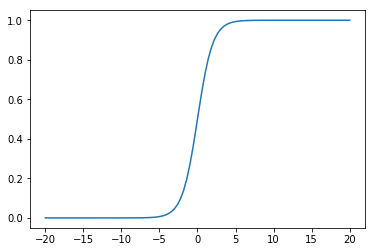

In [222]:
sample_x = np.linspace(-20,20,100)
plt.plot(sample_x,sigmoid(sample_x))
plt.show()

Hence to implement in python we just need to define the following function:

In [223]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

## Hypothesis
The output for a given sample is derived using the following formula
![Output](https://cdn-images-1.medium.com/max/800/1*p4hYc2VwJqoLWwl_mV0Vjw.png)

Here, 
- `g` - Sigmoid Function
- `theta` - Weight Matrix
- `z` - Output
- `h` - Activated Output 

## Prediction

Here we'll take the current weights and the input and calculate the activation output. 
This output will be used to calculate the cost and gradients for the optimisation function.

In [224]:
def predict(x,theta):
    z = (theta.T).dot(x)
    hx = sigmoid(z)
    # print "Shape after activation: " + str(hx.shape)
    return hx

## Loss

**REFER : https://www.youtube.com/watch?v=K0YBDyxEXKE**

![Loss](https://cdn-images-1.medium.com/max/800/1*FdxEs8Iv_43Q8calTCjnow.png)

Here the **cost** or *loss* is calculated.
The loss is basically the error between the predicted output and the actual output for that case.


In [225]:
def loss(h, y):
    return np.sum(np.negative(y.T) * np.log(h) - (1 - y).T * (np.log(1 - h))) / y.shape[1]

## Gradient
![Grad formula](https://cdn-images-1.medium.com/max/800/1*gobKgGbRWDAoVFAan_HjxQ.png)

Now to optimise our error ( minimise the error ) we'll use a strategy called [Gradient Descent](https://machinelearningmastery.com/gradient-descent-for-machine-learning/
) which will help us minimise the error between the actual values and our predicted values.

To do this we'll calculate the **gradient** for our current iteration of weights. The gradient can simply be understood as a small delta ( change ) we should bring about in our weights to move closer to an optimimum solution.

In [226]:
def gradient(X,h,y):
    return (1.0 / y.shape[0]) * np.dot(X, (h.T - y))

## Forward Propogation (Application of Activation Function)

This function will implement the above functions in the described order. We're basically putting everything together.

The basic algorithm is as follows:

1. Predict the output
2. Use the predicted output to calculate the cost.
3. Find the gradient 
4. Update the weights based on the gradient
5. Do 1 - 4 Again until convergence


In [227]:
def get_gradient(theta, b, x, y):
    # Predicting the output
    y_estimate = predict(x,theta)
    
    # Use the predicted output to calculate the cost.
    error = loss(y_estimate,y)
    
    # Find the gradient
    grad = gradient(x,y_estimate,y)
    
    # Update the weights based on the gradient
    error = np.squeeze(error)
    
    return grad,error

## Iteratively Updating the Weights

Now we've finally reached the stage where we can start putting all the above functions to use and train our model.

We'll first initialize our array of weights. The shape is (4, 3) because we have 4 input features and 3 output classes.

Since there's multiple classes the correct function to use here would be a [Softmax Function](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax) but we'll simply find class with maximum confidence and consider that to be the predicted output.

Here the steps are simple:

1. Fetch the gradient for the current iteration using get_gradient()
2. Update the weights
3. Check for convergence with the tolerance
4. If converged stop and return the current weights, bias and error.

In [228]:
def learn(alpha = 0.1, tolerance = 1e-4): 
    # Initialising a random vector of weight
    theta = np.zeros((4,3))
    b = 0
    
    # Here the learning rate, and tolerance are passed as parameters.
    print "Learning Rate: " + str(alpha)
    print "Tolerance: " + str(tolerance)

    # Perform Gradient Descent
    iterations = 1
    print "Weights: "
    print theta
    while True:
        theta_gradient, error = get_gradient(theta, b, train_x, train_y)
        theta_new = theta - (alpha * theta_gradient)

        # Stopping Condition: We define convergence based on the error tolerance.
        if np.sum(abs(theta_new - theta)) < tolerance:
            print ("Converged.")
            break

        # Print error every 50 iterations
        if iterations % 50 == 0:
            print ("Iteration: "+str(iterations)+" - Error: "+ str(np.sum(error)))

        iterations += 1

        theta = theta_new
        errorold = error

    return theta, b, error

## Training

That's it. Now we just have to call our training function with the necessary parameters and see our model train with the provided data.

In [193]:
#Let's train the model:
weights, beta, error_final = learn()

Learning Rate: 0.1
Tolerance: 0.0001
Weights: 
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
Iteration: 50 - Error: 41.85552540842361
Iteration: 100 - Error: 37.123021090391696
Iteration: 150 - Error: 34.807879269468174
Iteration: 200 - Error: 33.27764259055146
Iteration: 250 - Error: 32.144236615399535
Iteration: 300 - Error: 31.255369820382327
Iteration: 350 - Error: 30.53402491785185
Iteration: 400 - Error: 29.93494892295152
Iteration: 450 - Error: 29.42888583304322
Iteration: 500 - Error: 28.995669013831634
Iteration: 550 - Error: 28.620755984465518
Iteration: 600 - Error: 28.29330643871076
Iteration: 650 - Error: 28.005032159154705
Iteration: 700 - Error: 27.74946753808091
Iteration: 750 - Error: 27.52148536530038
Iteration: 800 - Error: 27.316963604368805
Iteration: 850 - Error: 27.132549280600227
Iteration: 900 - Error: 26.965487106809196
Iteration: 950 - Error: 26.813492564864703
Iteration: 1000 - Error: 26.67465628500645
Iteration: 1050 - Error: 26.547370930756585
Iteration

Iteration: 10400 - Error: 23.982183000346268
Iteration: 10450 - Error: 23.980867228191272
Iteration: 10500 - Error: 23.979565721524775
Iteration: 10550 - Error: 23.978278269912057
Iteration: 10600 - Error: 23.977004666954503
Iteration: 10650 - Error: 23.97574471019391
Iteration: 10700 - Error: 23.97449820101949
Iteration: 10750 - Error: 23.973264944577426
Iteration: 10800 - Error: 23.972044749682976
Iteration: 10850 - Error: 23.97083742873495
Iteration: 10900 - Error: 23.96964279763266
Iteration: 10950 - Error: 23.968460675695002
Iteration: 11000 - Error: 23.96729088558187
Iteration: 11050 - Error: 23.966133253217617
Iteration: 11100 - Error: 23.964987607716704
Iteration: 11150 - Error: 23.963853781311187
Iteration: 11200 - Error: 23.96273160928035
Iteration: 11250 - Error: 23.961620929882077
Iteration: 11300 - Error: 23.960521584286095
Iteration: 11350 - Error: 23.959433416509043
Iteration: 11400 - Error: 23.958356273351182
Iteration: 11450 - Error: 23.957290004334823
Iteration: 11500

Iteration: 22100 - Error: 23.85355323575519
Iteration: 22150 - Error: 23.853349742288383
Iteration: 22200 - Error: 23.85314750535342
Iteration: 22250 - Error: 23.852946515244735
Iteration: 22300 - Error: 23.85274676234856
Iteration: 22350 - Error: 23.852548237141885
Iteration: 22400 - Error: 23.85235093019138
Iteration: 22450 - Error: 23.85215483215247
Iteration: 22500 - Error: 23.851959933768242
Iteration: 22550 - Error: 23.851766225868516
Iteration: 22600 - Error: 23.851573699368828
Iteration: 22650 - Error: 23.85138234526951
Iteration: 22700 - Error: 23.851192154654708
Iteration: 22750 - Error: 23.85100311869145
Iteration: 22800 - Error: 23.850815228628733
Iteration: 22850 - Error: 23.850628475796597
Iteration: 22900 - Error: 23.850442851605234
Iteration: 22950 - Error: 23.850258347544095
Iteration: 23000 - Error: 23.850074955181015
Iteration: 23050 - Error: 23.849892666161338
Iteration: 23100 - Error: 23.84971147220706
Iteration: 23150 - Error: 23.849531365116036
Iteration: 23200 -

Iteration: 33950 - Error: 23.826869248116722
Iteration: 34000 - Error: 23.826811453048787
Iteration: 34050 - Error: 23.826753923726574
Iteration: 34100 - Error: 23.8266966586543
Iteration: 34150 - Error: 23.82663965634612
Iteration: 34200 - Error: 23.82658291532608
Iteration: 34250 - Error: 23.826526434128
Iteration: 34300 - Error: 23.826470211295415
Iteration: 34350 - Error: 23.826414245381514
Iteration: 34400 - Error: 23.826358534949055
Iteration: 34450 - Error: 23.826303078570273
Iteration: 34500 - Error: 23.826247874826834
Iteration: 34550 - Error: 23.82619292230973
Iteration: 34600 - Error: 23.826138219619256
Iteration: 34650 - Error: 23.826083765364885
Iteration: 34700 - Error: 23.826029558165242
Iteration: 34750 - Error: 23.82597559664799
Iteration: 34800 - Error: 23.825921879449805
Iteration: 34850 - Error: 23.82586840521626
Iteration: 34900 - Error: 23.825815172601825
Iteration: 34950 - Error: 23.82576218026971
Iteration: 35000 - Error: 23.825709426891866
Iteration: 35050 - Er

## What Just Happened?

So we've run our function. 

After 42300 iterations we can see that the model has *converged*. But why is the training error so high?

It's **23.8200 %** as can be seen.
But why is it that high? 

**So we admit it we cheated a little bit**. Since we're having 3 possible classes for prediction we should technically use an activation function that balances the probability such that the total sum of the probabalities for each class together would be 1. 

But here we're just considering them to be independent probabilities and taking the maximum one to determine the class. Hence the error will always be calculated from either 0 or 1. Hence when you look at an output it will never present an example like (1, 0, 0). There'll definitely be some error in at least one of the classes. Hence that error adds up. 

So next time we do a classification problem with multiple classes we'll actually use a **softmax** layer which will help perform better for this kind of problem.

## Testing and Validation

Now that we've retreived a final set of weights and the bias after training we'll use these values to predict values in our test set and validate the model. 

We can use a variation of our prediction function and find the class that has maximum probability to determine the result for each test tuple.

In [229]:
result = predict(test_x, weights)

print result.T

[[9.99e-01 2.23e-01 1.49e-13]
 [5.15e-07 1.06e-01 8.54e-01]
 [1.00e+00 1.69e-01 1.37e-13]
 [5.16e-08 2.47e-01 9.91e-01]
 [6.14e-08 8.28e-01 4.86e-01]
 [1.00e+00 1.75e-01 6.87e-14]
 [1.00e+00 1.45e-01 8.52e-15]
 [9.59e-09 4.88e-01 9.96e-01]
 [1.86e-04 6.35e-01 1.70e-03]
 [1.98e-08 7.76e-02 1.00e+00]
 [9.52e-05 4.12e-01 4.09e-03]
 [1.99e-09 8.61e-01 9.95e-01]
 [8.91e-06 7.50e-01 1.29e-02]
 [6.56e-09 2.89e-01 1.00e+00]
 [1.00e+00 1.67e-01 1.35e-15]
 [1.17e-05 5.48e-01 7.85e-03]
 [8.59e-09 2.94e-01 1.00e+00]
 [3.72e-09 8.16e-01 9.99e-01]
 [2.82e-08 1.84e-01 9.97e-01]
 [1.00e+00 1.27e-01 3.73e-16]
 [3.90e-08 6.28e-02 1.00e+00]
 [1.00e+00 7.83e-02 1.73e-14]
 [1.00e+00 6.45e-02 3.71e-16]
 [9.99e-01 2.18e-01 4.93e-13]
 [1.00e+00 5.55e-02 1.47e-15]
 [9.99e-01 2.04e-01 8.08e-14]
 [1.00e+00 2.41e-01 1.09e-15]
 [3.79e-10 7.73e-01 1.00e+00]
 [2.20e-03 2.24e-01 8.08e-05]
 [1.44e-06 2.64e-01 7.59e-01]]


So these are the actual results from the model. We can see that we get probabilities of each class but the sum isn't necessarily 1.

In [230]:
print np.sum(result, axis=0)

[1.22 0.96 1.17 1.24 1.31 1.17 1.15 1.48 0.64 1.08 0.42 1.86 0.76 1.29
 1.17 0.56 1.29 1.82 1.18 1.13 1.06 1.08 1.06 1.22 1.06 1.2  1.24 1.77
 0.23 1.02]


### Results from Model

In [231]:
predicted_result = np.argmax(result.T, axis=1)
print predicted_result

[0 2 0 2 1 0 0 2 1 2 1 2 1 2 0 1 2 2 2 0 2 0 0 0 0 0 0 2 1 2]


### Actual Results

In [232]:
actual_result = test_y_non_ohe[0]
print actual_result

[0 2 0 2 2 0 0 2 1 2 1 2 1 2 0 1 2 2 2 0 2 0 0 0 0 0 0 2 1 2]


Let's quickly visualize this with a confusion matrix.

### Confusion Matrix

A *confusion matrix* is a specific table layout that allows visualization of the performance of an algorithm. So we can easily see our results and the accuracy of the model itself.

You can actually **ignore** the next cell as it's just a function to plot the confusion matrix but we've included it in case you want to see how it's done.

In [236]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Now we'll generate the confusion matrix

In [237]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(actual_result, predicted_result)

### Plotting

Confusion matrix, without normalization
[[12  0  0]
 [ 0  5  0]
 [ 0  1 12]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   1.   0.  ]
 [0.   0.08 0.92]]


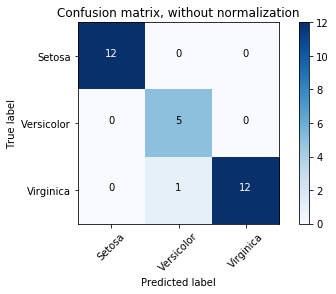

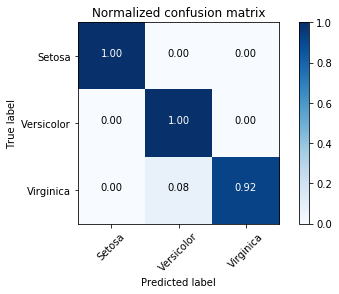

In [238]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(matrix, classes=["Setosa", "Versicolor", "Virginica"],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(matrix, classes=["Setosa", "Versicolor", "Virginica"], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### Analysing the results

So as can be seen the model classified **ONLY ONE** test tuple incorrectly. Hence the accuracy is actually:

29 / 30 ~= 0.9667

Hence our model has:

**Non-normalized** training error of **23.82 points**.
<br>
**Testing** accuracy of **96.67 %**.

So we haven't really done all that bad. But we still have to get to concepts like overfitting and also understand that the amount of data we have is very little so that's pretty much why our model performed so *"well"*.<br>
And hopefully you understand why the training accuracy turned out so low when in fact the model performed well enough in the testing set.

As usual message us on Slack with any questions or reach out to: <br> 
me at shreyas.gopal.ind@gmail.com or <br>
Vishal at vishstar88@gmail.com